In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset'
train_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/train'
train_nowheel_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/train/nowheel'
train_wheel_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/train/wheel'
test_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/test'
test_nowheel_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/test/nowheel'
test_wheel_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/test/wheel'
valid_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/validation'
valid_nowheel_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/validation/nowheel'
valid_wheel_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/validation/wheel'

In [ ]:
num_nowheel_train = len(os.listdir(train_nowheel_dir))
num_wheel_train = len(os.listdir(train_wheel_dir))
num_nowheel_validation = len(os.listdir(valid_nowheel_dir))
num_wheel_validation= len(os.listdir(valid_wheel_dir))
num_nowheel_test = len(os.listdir(test_nowheel_dir))
num_wheel_test= len(os.listdir(test_wheel_dir))

In [ ]:
print("Total Training Nowheel Images",num_nowheel_train)
print("Total Training Wheel Images",num_wheel_train)
print("--")
print("Total validation Nowheel Images",num_nowheel_validation)
print("Total validation Wheel Images",num_wheel_validation)
print("--")
print("Total Test Nowheel Images", num_nowheel_test)
print("Total Test Wheel Images",num_wheel_test)
print("--")
total_train = num_nowheel_train+num_wheel_train
total_validation = num_nowheel_validation+num_wheel_validation
total_test = num_nowheel_test+num_wheel_test
print("--")
print("Total Images",total_train + total_validation + total_test)
print("Total Training Images",total_train)
print("--")
print("Total Validation Images",total_validation)
print("--")
print("Total Testing Images",total_test)

Total Training Nowheel Images 427
Total Training Wheel Images 2439
--
Total validation Nowheel Images 92
Total validation Wheel Images 523
--
Total Test Nowheel Images 91
Total Test Wheel Images 522
--
--
Total Images 4094
Total Training Images 2866
--
Total Validation Images 615
--
Total Testing Images 613


In [ ]:
IMG_SHAPE  = 224
batch_size = 32

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
directory = train_dir,
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'binary')
label_map = (train_data_gen.class_indices)

image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
directory=valid_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')

image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
directory=test_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')

Found 2866 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 613 images belonging to 2 classes.


In [ ]:
from glob import glob
class_names = glob(train_dir + "/*")
class_names = sorted(class_names)
name_id_map = dict(zip(class_names, range(len(class_names))))
print(name_id_map)

{'/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/train/nowheel': 0, '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/dataset/train/wheel': 1}


In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  print(layer.name)
  layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [ ]:
model = tf.keras.Model(pre_trained_model.input, x)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [ ]:
vgg_classifier = model.fit(train_data_gen,
steps_per_epoch=(total_train//batch_size),
epochs = 50,
validation_data=val_data_gen,
validation_steps=(total_validation//batch_size),
batch_size = batch_size,
verbose = 1)

Epoch 1/50
89/89 [==============================] - 762s 8s/step - loss: 0.5193 - acc: 0.8232 - val_loss: 0.3479 - val_acc: 0.8701
Epoch 2/50
89/89 [==============================] - 40s 444ms/step - loss: 0.3647 - acc: 0.8603 - val_loss: 0.3218 - val_acc: 0.8766
Epoch 3/50
89/89 [==============================] - 40s 445ms/step - loss: 0.3398 - acc: 0.8641 - val_loss: 0.3155 - val_acc: 0.8717
Epoch 4/50
89/89 [==============================] - 41s 455ms/step - loss: 0.3132 - acc: 0.8783 - val_loss: 0.2833 - val_acc: 0.8849
Epoch 5/50
89/89 [==============================] - 40s 454ms/step - loss: 0.3018 - acc: 0.8850 - val_loss: 0.2869 - val_acc: 0.8783
Epoch 6/50
89/89 [==============================] - 40s 454ms/step - loss: 0.2960 - acc: 0.8804 - val_loss: 0.2804 - val_acc: 0.8849
Epoch 7/50
89/89 [==============================] - 40s 449ms/step - loss: 0.2883 - acc: 0.8888 - val_loss: 0.2683 - val_acc: 0.8882
Epoch 8/50
89/89 [==============================] - 40s 452ms/step - lo

In [ ]:
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",result)

20/20 [==============================] - 401s 21s/step - loss: 0.2914 - acc: 0.9038
test_loss, test accuracy [0.2913897633552551, 0.9037520289421082]


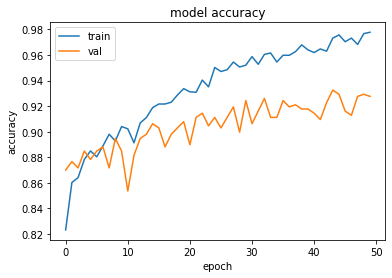

In [ ]:
from matplotlib import pyplot as plt
plt.plot(vgg_classifier.history['acc'])
plt.plot(vgg_classifier.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

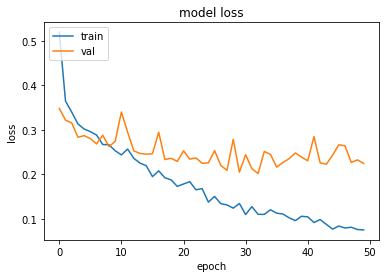

In [ ]:
from matplotlib import pyplot as plt
plt.plot(vgg_classifier.history['loss'])
plt.plot(vgg_classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/VGG_Wheelchair_Classifier.json", "w") as json_file:
  json_file.write(model_json)
  model.save("/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/VGG_Wheelchair_Classifier.h5")
  print("Saved model to disk")
  model.save_weights("/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/VGG_Wheelchair_Weights.h5")

Saved model to disk
